# 6. Интерпретация модели

## 🎯 Цели этапа
1. SHAP анализ для понимания предсказаний
2. Анализ бизнес-влияния признаков  
3. Создание рекомендаций для отдела маркетинга
4. Прототип прогнозирования для новых клиентов

In [1]:
import shap
import joblib
import pandas as pd

import sys
import os

os.chdir('..')

sys.path.insert(0, 'src')

from data_preparation import PrepareData

os.chdir('notebooks')

shap.initjs() # Для лучшей визуализации графиков

scaler = joblib.load('../data/processed/scaler.pkl')

df = pd.read_csv('../data/bank_churn_preprocessing.csv')
best_model = joblib.load('../models/catboost_tuned_20251010_190010.pkl')

preparing = PrepareData(df)
X_train, X_test, y_train, y_test = preparing.splitting()

X_train, y_train = preparing.balancing_classes()

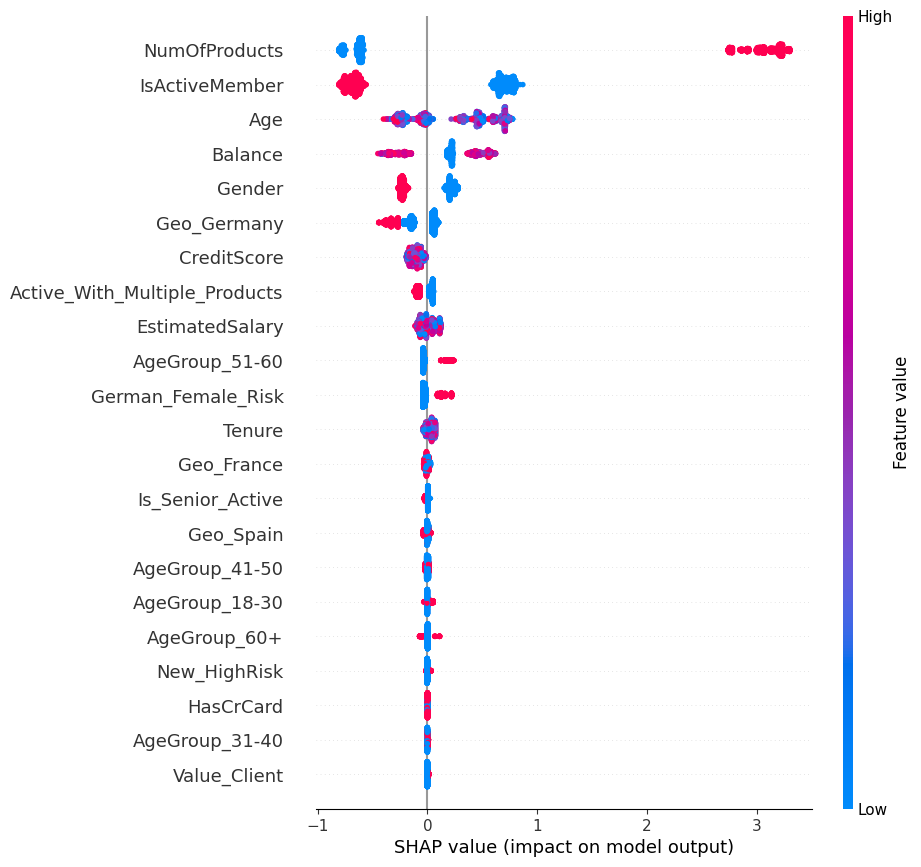

In [3]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=25)

## 🎨Интерпретация графика beeswarm

График `beeswarm` сортирует признаки по наибольшему вкладу в прогноз. Топ-6 признаков:

* NumOfProducts
* IsActiveMember
* Age
* Balance
* Gender
* Geo_Germany 

**Пояснение к графику:**

- Каждый точечный элемент — отдельный пример из теста.

- По вертикали — признаки, упорядоченные по средней важности.

- По горизонтали — SHAP-значения: смещение вкладом признака от базового вывода.

- Цвет точек — значение признака (например, синий — низкое, красный — высокое).

**Как читать:**

- Если красные точки правее — большой вклад высоких значений признака в отток.

- Синее смещение влево — низкие значения признака уменьшают вероятность оттока.

Все, что **правее** (положительные значения SHAP-value) центральной вертикальной прямой (SHAP-value = 0) - увеличивает вероятность оттока; **левее** (отрицательные значение SHAP value) - уменьшает вероятность оттока. **Цвет** отвечает за важность признака (красный - высокое значение, синий - низкое значение)

### Выводы по графику

- Количество продуктов (NumOfProducts) - оказывает самое сильное влияние на то, продолжит ли пользоваться клиент услугами банк
- По мере увеличения количества продуктов клиент с большой вероятностью перестанет пользоваться услугами банка
- Активные пользователи менее склонны к оттоку
- Молодые люди менее склонны к оттоку. С увеличением возраста клиент чуть более вероятнее перестанет пользоваться услугами банка
- Люди с высоким балансом чуть более склонны к оттоку, нежели люди с низким балансом
- Женщины наиболее лояльны
- Люди из Германии лояльнее

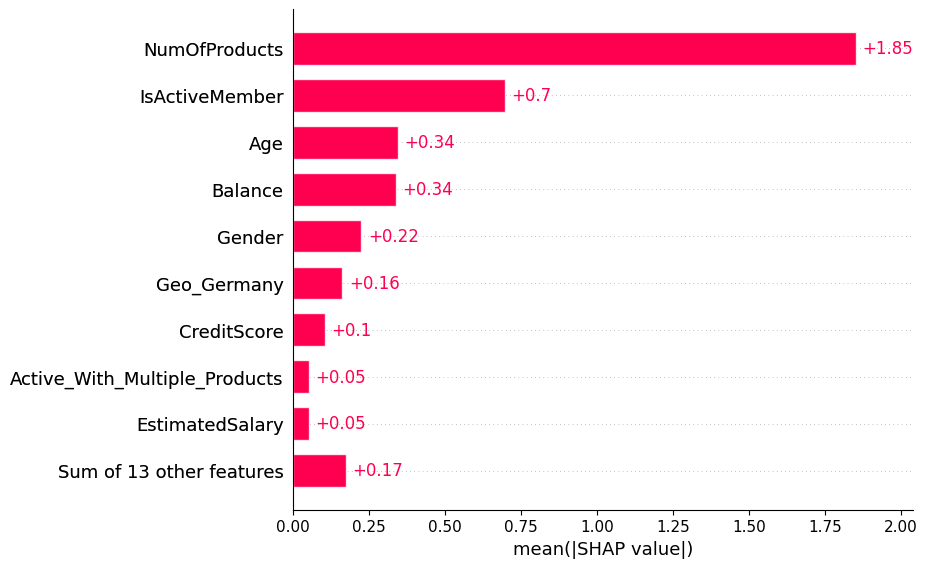

In [4]:
shap.plots.bar(shap_values)

### 📶Bar plot

По данному графику гистограммы мы можем понять, какой численный вклад вносит каждый признак в предсказание.

- Показывает средние по модулю значения SHAP признаков.

- Используется для оценки глобальной важности признаков, т.е. на какие признаки модель обращает внимание чаще и сильнее.

- Как читать: самые длинные столбцы — самые влиятельные признаки для модели.

Наибольший вклад вносят признаки `NumOfProducts`, `IsActiveMember`, `Age`, `Balance`, `Gender`

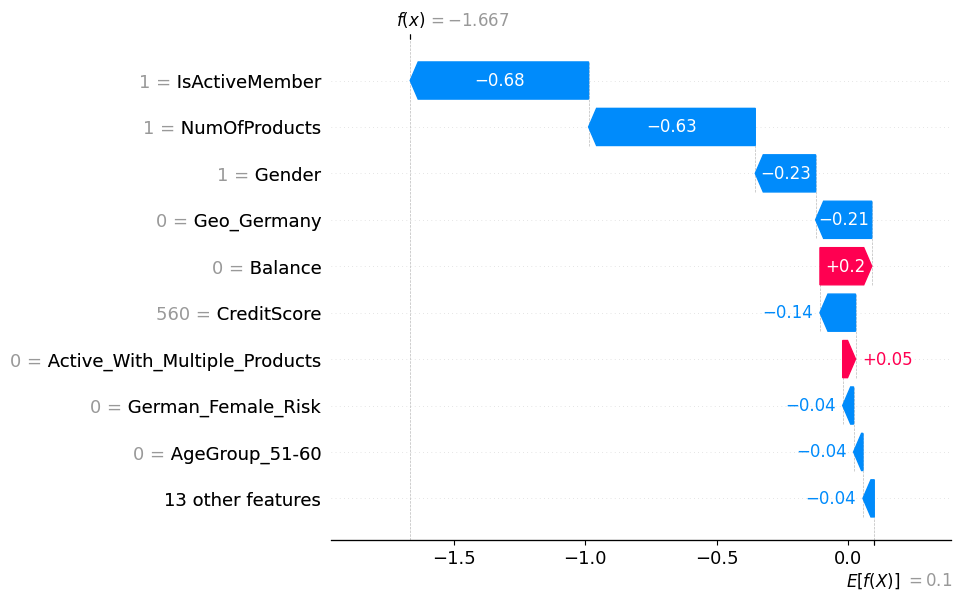

In [5]:
shap.plots.waterfall(shap_values[0])

### 🏞️Waterfall график

Waterfall график представляет детализированное объяснение предсказания для одного конкретного клиента. Начинается со среднего прогноза модели по датасету (базового значения).

- Каждый блок показывает, как конкретный признак увеличивает или уменьшает прогноз относительно базового.

- Красные блоки приближают к целевому классу (отток), синие — отдаляют.

Рассмотрим конкретный пример, какой вклад вносят наши признаки на отдельное предсказание.

Для данного клиента видим, что он является активным пользователем с одним продуктом банка. Мужчина живет в Германии и не хранит деньги в банке. Суммарная оценка нашего предсказания равна f(x) = -1.667, что говорит нам о том, что клиент с большой вероятностью является лояльным

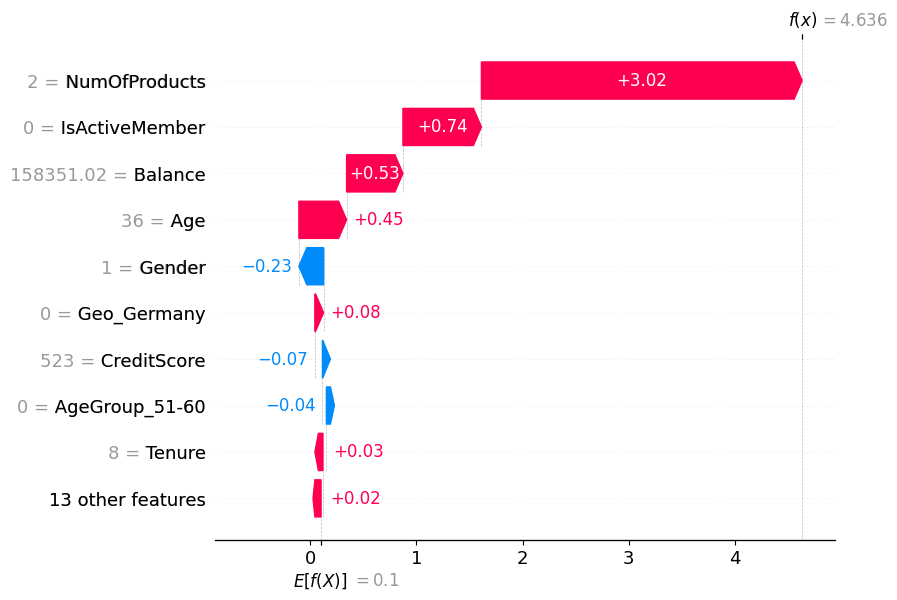

In [6]:
shap.plots.waterfall(shap_values[1])

Рассмотрим теперь второе предсказание. У мужчины имеется 2 банковских продукта, много денежных средств на балансе банка, но при этом у него неактивный статус. Возраст мужчины 36 лет, что является балансом возраста. Общая оценка модели f(x) = 4.636, что говорит о большом риске ухода данного клиента.

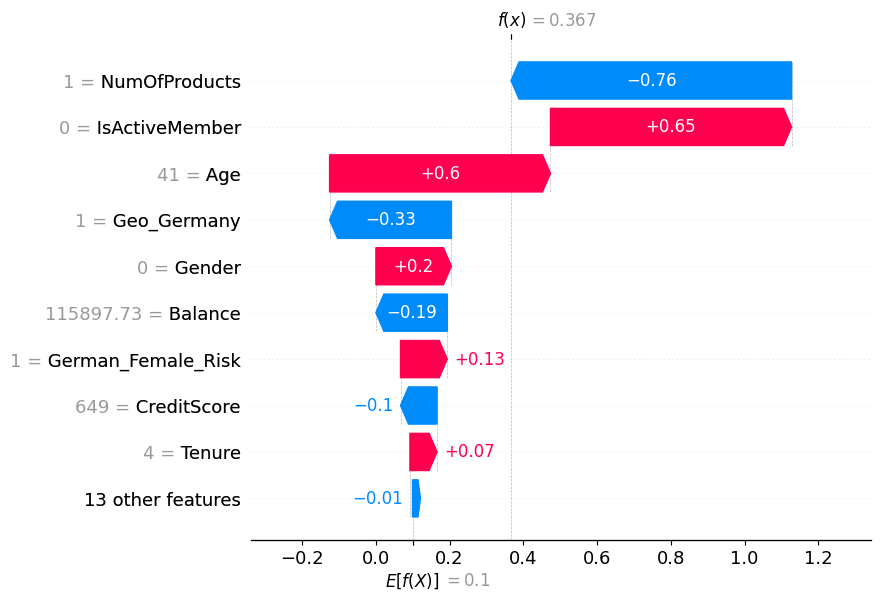

In [7]:
shap.plots.waterfall(shap_values[2])

Рассмотрим третье предсказание. У женщины имеется один продукт в банке, что вносит вклад в лояльность. Но поскольку ее возраст составляет 41 год, и она является неактивным пользователем, эти характеристики увеличивают риск оттока клиента. Из-за того, что женщина проживает в Германии и баланс на ее счете большой, происходит еще один перевес в сторону лояльности. Итог - данный клиент является стабильным с низкой вероятностью подходит под отток